In [1]:
import keras
keras.__version__

from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/Yoann/anaconda2/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Using convnets with small datasets

This notebook contains the code sample found in Chapter 5, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures.

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve our network to reach an accuracy of 82%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: *doing feature extraction with a pre-trained network* (this will get us to an accuracy of 90% to 93%), and *fine-tuning a pre-trained network* (this will get us to our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer vision with small datasets.

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can potentially suffice if the model is small and well-regularized and if the task is simple. Because convnets learn local, translation-invariant features, they are very data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results 
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## 1 - Training a convnet from scratch

### 1.1 - Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: `https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the 
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our models on less than 10% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

In [2]:
import os, shutil

In [3]:
# The directory where our smaller dataset is stored
base_dir = '../../data/cats_and_dogs_small/'

In [4]:
# Directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [5]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

('total training cat images:', 1001)


In [7]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))

('total training dog images:', 1001)


In [8]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

('total validation cat images:', 501)


In [9]:
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

('total validation dog images:', 501)


In [10]:
print('total test cat images:', len(os.listdir(test_cats_dir)))

('total test cat images:', 501)


In [11]:
print('total test dog images:', len(os.listdir(test_dogs_dir)))

('total test dog images:', 501)



So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.

### 1.2 - Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a `sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

Let's build our neural network, using the `Sequential` API.

> Here's the network's building blocks : 
- Conv2D Layer : 32 filters, (3, 3) kernel, relu activation, input shape (150, 150, 3)
- MaxPooling2D : pool size (2, 2)
- Conv2D Layer : 64 filters, (3, 3) kernel, relu activation
- MaxPooling2D : pool size (2, 2)
- Conv2D Layer : 128 filters, (3, 3) kernel, relu activation
- MaxPooling2D : pool size (2, 2)
- Conv2D Layer : 128 filters, (3, 3) kernel, relu activation
- MaxPooling2D : pool size (2, 2)
- Flatten (no parameters)
- Dense Layer : 512 neurons, relu activation
- Dense Layer : 1 neuron, sigmoid activation

Documentation Conv2D: https://keras.io/layers/convolutional/#conv2d

Documentation MaxPooling2D: https://keras.io/layers/pooling/#maxpooling2d

Documentation Flatten : https://keras.io/layers/core/#flatten

In [12]:
from keras import layers
from keras import models

In [13]:
# Q1.2 : Create the layers of the neural network using the Sequential API from Keras

model = models.Sequential()

# YOUR CODE BELOW
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

### 1.3 - Compile the Network

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss.

Implement the following compilation step for your Neural Network : 
- "rmsprop" optimizer, learning rate 1e-4
- "binary_crossentropy" loss
- metric : "accuracy"

Documentation : https://keras.io/getting-started/sequential-model-guide/#compilation

In [15]:
from keras import optimizers

In [16]:
# Q1.3 : Add the compilation step to the network

# YOUR CODE BELOW
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 1.4 - Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

In [17]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Implement the train generator using the `flow_from_directory` method of the image generators, using the following arguments : 
- directory : `train_dir`
- target size : (150, 150) -> All images will be resized to 150x150
- batch size : 20
- class mode : `binary` -> Since we use binary_crossentropy loss, we need binary labels

Documentation ImageDataGenerator: https://keras.io/preprocessing/image/#imagedatagenerator

Documentation flow_from_directory : https://keras.io/preprocessing/image/#flow_from_directory

In [18]:
# Q1.4.1 : Implement the train generator

# YOUR CODE BELOW
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 2000 images belonging to 2 classes.


Implement the validation generator likewise, using the following arguments : 
- directory : `validation_dir`
- target size : (150, 150)
- batch size : 20
- class mode : `binary`

In [19]:
# Q1.4.1 : Implement the validation generator

# YOUR CODE BELOW
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


### 1.5 - Fit the model

Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 

Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

Train the model using the `fit_generator` method, using the following arguments : 
- generator : the train generator
- steps_per_epoch : 100
- 30 epochs
- validation_data : the validation generator
- 50 validation steps

Documentation : https://keras.io/models/sequential/#fit_generator

In [20]:
# Q1.5 : Fit the model using the fit_generator method

# YOUR CODE BELOW
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/10
100/100 [==============================] - 71s 708ms/step - loss: 0.6883 - acc: 0.5370 - val_loss: 0.6758 - val_acc: 0.5840
Epoch 2/10
100/100 [==============================] - 67s 667ms/step - loss: 0.6521 - acc: 0.6040 - val_loss: 0.6326 - val_acc: 0.6450
Epoch 3/10
100/100 [==============================] - 64s 637ms/step - loss: 0.6046 - acc: 0.6795 - val_loss: 0.6005 - val_acc: 0.6620
Epoch 4/10
100/100 [==============================] - 63s 633ms/step - loss: 0.5631 - acc: 0.7040 - val_loss: 0.6655 - val_acc: 0.6070
Epoch 5/10
100/100 [==============================] - 63s 630ms/step - loss: 0.5354 - acc: 0.7270 - val_loss: 0.6485 - val_acc: 0.6270
Epoch 6/10
100/100 [==============================] - 63s 631ms/step - loss: 0.5118 - acc: 0.7435 - val_loss: 0.5795 - val_acc: 0.6720
Epoch 7/10
100/100 [==============================] - 64s 643ms/step - loss: 0.4809 - acc: 0.7655 - val_loss: 0.5502 - val_acc: 0.7160
Epoch 8/10
100/100 [==============================] - 7

It is good practice to always save your models after training:

In [21]:
model.save('cats_and_dogs_small_1.h5')

If the training takes too much time, for the sake of the exercice, you can load the model that was trained using the same procedure using the following lines of code (note that you won't be able to plot the history of the training of the model) :

In [ ]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_1.h5')

### 1.6 - Plot the results

Let's plot the loss and accuracy of the model over the training and validation data during training.

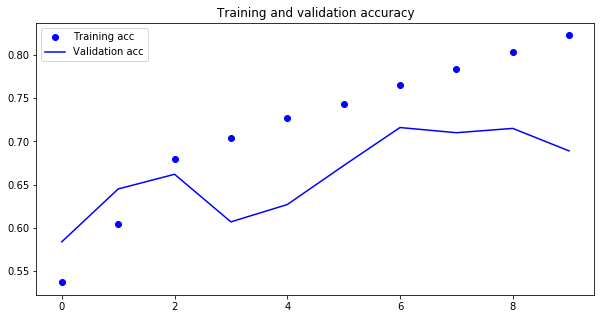

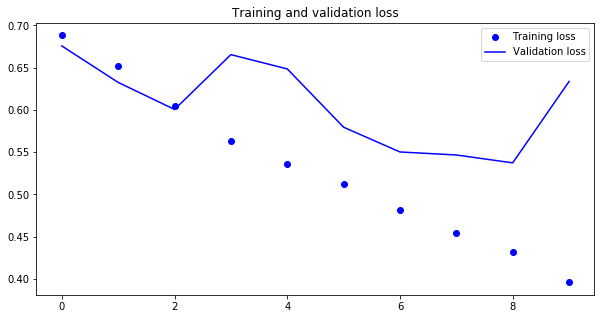

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(10,5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to 
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data 
augmentation*.

## 2 - Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 

Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

### 2.1 - Define a Generator

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance.

In [23]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

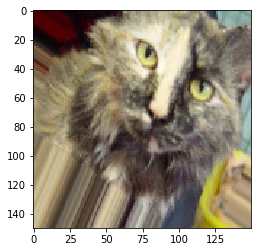

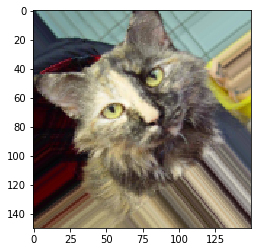

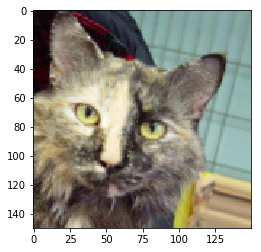

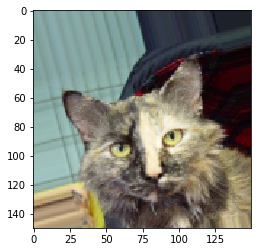

In [24]:
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

### 2.2 - Define the network

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier.

Let's build our neural network, using the `Sequential` API. It is the same as before, with one additional Dropout layer.

> Here's the network's building blocks : 
- Conv2D Layer : 32 filters, (3, 3) kernel, relu activation, input shape (150, 150, 3)
- MaxPooling2D : pool size (2, 2)
- Conv2D Layer : 64 filters, (3, 3) kernel, relu activation
- MaxPooling2D : pool size (2, 2)
- Conv2D Layer : 128 filters, (3, 3) kernel, relu activation
- MaxPooling2D : pool size (2, 2)
- Conv2D Layer : 128 filters, (3, 3) kernel, relu activation
- MaxPooling2D : pool size (2, 2)
- Flatten (no parameters)
- Dropout layer : rate 0.5
- Dense Layer : 512 neurons, relu activation
- Dense Layer : 1 neuron, sigmoid activation

Documentation Conv2D: https://keras.io/layers/convolutional/#conv2d

Documentation MaxPooling2D: https://keras.io/layers/pooling/#maxpooling2d

Documentation Flatten : https://keras.io/layers/core/#flatten

Documentation Dropout : https://keras.io/layers/core/#dropout

In [25]:
# Q2.2.1 : Create the layers of the neural network using the Sequential API from Keras

model = models.Sequential()

# YOUR CODE BELOW
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Implement the following compilation step for your Neural Network : 
- "rmsprop" optimizer, learning rate 1e-4
- "binary_crossentropy" loss
- metric : "accuracy"

Documentation : https://keras.io/getting-started/sequential-model-guide/#compilation

In [26]:
# Q2.2.2 : Create the layers of the neural network using the Sequential API from Keras

# YOUR CODE BELLOW
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's define the generators.

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

Implement the train and validation generators, which are the same as before except a batch size of 32 (we can increase the batch size because we are artificially increasing the amount of available data)

In [28]:
# Q2.2.1 : Implement the train generator

# YOUR CODE BELOW
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [29]:
# Q2.2.2 : Implement the validation generator

# YOUR CODE BELOW
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


### 2.3 - Fit the network

Train the model using the `fit_generator` method, using the following arguments : 
- generator : the train generator
- steps_per_epoch : 100
- 100 epochs
- validation_data : the validation generator
- 50 validation steps

Documentation : https://keras.io/models/sequential/#fit_generator

In [30]:
# Q2.3 : Fit the network using the fit_generator method

# YOUR CODE BELOW
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 102s 1s/step - loss: 0.6925 - acc: 0.5231 - val_loss: 0.6842 - val_acc: 0.5184
Epoch 2/100
100/100 [==============================] - 102s 1s/step - loss: 0.6783 - acc: 0.5794 - val_loss: 0.6616 - val_acc: 0.6009
Epoch 3/100
100/100 [==============================] - 101s 1s/step - loss: 0.6679 - acc: 0.5919 - val_loss: 0.7751 - val_acc: 0.5019
Epoch 4/100
100/100 [==============================] - 103s 1s/step - loss: 0.6544 - acc: 0.6184 - val_loss: 0.6207 - val_acc: 0.6536
Epoch 5/100
100/100 [==============================] - 102s 1s/step - loss: 0.6407 - acc: 0.6388 - val_loss: 0.6070 - val_acc: 0.6713
Epoch 6/100
100/100 [==============================] - 101s 1s/step - loss: 0.6212 - acc: 0.6484 - val_loss: 0.5841 - val_acc: 0.6758
Epoch 7/100
100/100 [==============================] - 102s 1s/step - loss: 0.6119 - acc: 0.6616 - val_loss: 0.5589 - val_acc: 0.6999
Epoch 8/100
100/100 [==============================] - 102s 1s

Let's save our model -- we will be using it in the section on convnet visualization.

In [31]:
model.save('cats_and_dogs_small_2.h5')

If the training takes too much time, for the sake of the exercice, you can load the model that was trained using the same procedure using the following lines of code (note that you won't be able to plot the history of the training of the model) :

In [ ]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')

### 2.4 - Plot the results

Let's plot our results again:

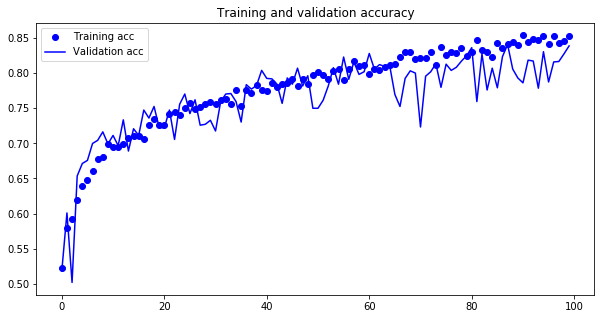

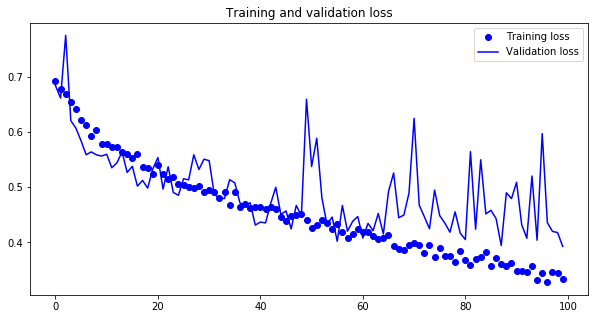

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10,5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. 

As a next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next sections.